In [1]:
from src.epl_proyection.etl import read_clean_geih
from src.epl_proyection.utils import calendar_features
from src.epl_proyection.etl import read_informal_geih
from src.epl_proyection.etl import preprocessing
from src.epl_proyection.utils import ts_diagnostics
from src.epl_proyection.models.arimax import arimax_forecast
from src.epl_proyection.models.arimax import arimax_grid_search
from src.epl_proyection.models.arimax import arimax_train_validate_forecast

In [2]:
df_labor = preprocessing.run_preprocessing_pipeline(path_df2='data/anex-GEIHEISS-nov2024-ene2025.xlsx',
                                                    sheet_name_df2='Grandes dominios ',
                                                    sector=['Agricultura, ganadería, caza, silvicultura y pesca','Industrias manufactureras'],
                                                    cols_to_lag=['Población en edad de trabajar (PET)', 'Población ocupada',
                                                                'Agricultura, ganadería, caza, silvicultura y pesca',
                                                                'Industrias manufactureras', 'Formal', 'Informal'])

In [3]:
df_labor['ds'] = df_labor['YearMonth']

# Forecast con ARIMAX

🔎 Diagnóstico de la serie original:
ADF Statistic: -4.7571
p-value: 0.0001
✅ La serie es estacionaria.


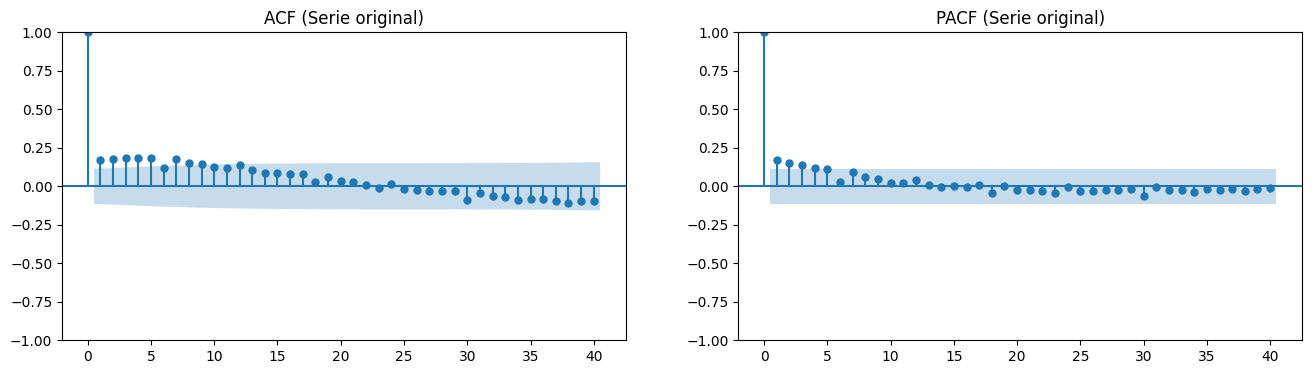

In [4]:
ts_diagnostics.full_ts_diagnostics(df_labor['logdiff_población en edad de trabajar (pet)'])

In [16]:
result = arimax_grid_search.arimax_grid_search_cv(
    df_labor,
    target_column='Población en edad de trabajar (PET)',
    ds_column= 'YearMonth',
    exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'],
    train_start="2001-01-01",
    train_end="2021-12-01",
    val_start="2022-01-01",
    val_end="2023-12-01",
    p_range=(0, 3),
    d_range=(1,1),
    q_range=(0, 3),
    seasonal_order=(0, 1, 1, 12),
    verbose=True
)

best_model = result['model']
best_order = result['best_order']


Probing ARIMAX(0, 1, 0) - MAE Validation: 0.00
Probing ARIMAX(0, 1, 1) - MAE Validation: 0.00
Probing ARIMAX(0, 1, 2) - MAE Validation: 0.00
Probing ARIMAX(0, 1, 3) - MAE Validation: 0.00
Probing ARIMAX(1, 1, 0) - MAE Validation: 0.00
Probing ARIMAX(1, 1, 1) - MAE Validation: 0.00
Probing ARIMAX(1, 1, 2) - MAE Validation: 0.00
Probing ARIMAX(1, 1, 3) - MAE Validation: 0.00
Probing ARIMAX(2, 1, 0) - MAE Validation: 0.00
Probing ARIMAX(2, 1, 1) - MAE Validation: 0.00
Probing ARIMAX(2, 1, 2) - MAE Validation: 0.00
Probing ARIMAX(2, 1, 3) - MAE Validation: 0.00
Probing ARIMAX(3, 1, 0) - MAE Validation: 0.00
Probing ARIMAX(3, 1, 1) - MAE Validation: 0.00
Probing ARIMAX(3, 1, 2) - MAE Validation: 0.00
Probing ARIMAX(3, 1, 3) - MAE Validation: 0.00

🏆 Best model found:
Order: (3, 1, 3) - MAE Validation: 0.00


In [19]:
result = arimax_forecast.train_validate_arimax(
    df_labor,
    target_column='Población en edad de trabajar (PET)',
    exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'],
    train_start="2001-01-01",
    train_end="2021-12-01",
    val_start="2022-01-01",
    val_end="2025-02-01",
    order=(3,1,3),
    seasonal_order=(0, 1, 1, 12)
)

print(result['metrics'])
forecast = result['forecast']

{'mae': 54.91899213933184, 'mse': 3579.5184834040747, 'mape': 0.0013794462307530314}


In [5]:
# Preparar exog_future y las fechas de predicción futura
# future_exog --> DataFrame con columnas de regresores
# future_dates --> pd.Series de fechas mensuales de marzo 2025 a diciembre 2040
# 1. Cortar df_labor a partir de marzo 2025
exog_columns = ['workdays', 'weekends', 'holidays','negative_crashes']
future_labor = df_labor[(df_labor['ds'] >= "2025-03-01") & (df_labor['ds'] <= "2040-12-01")]

# 2. Extraer los exógenos para predicción
future_exog = future_labor[exog_columns].copy()

# 3. Guardar las fechas
future_dates = future_labor['ds'].copy()


from src.epl_proyection.models.arimax import arimax_train_validate_forecast
result = arimax_train_validate_forecast.train_validate_forecast_arimax_full(
    df_labor,
    target_column='Población en edad de trabajar (PET)',
    exog_columns=exog_columns,
    future_exog=future_exog,
    future_dates=future_dates,
    order=(3,1,3),
    seasonal_order=(0,1,1,12)
)

# forecast_val y forecast_future ahora tienen 'ds' y 'forecast'
forecast_val = result['forecast_val']
forecast_future = result['forecast_future']

✅ MAE en Validación (2024-01-01 - 2025-02-01): 20.00


In [6]:
from src.epl_proyection.models.arimax.arimax_train_validate_forecast import train_full_forecast_arimax

result_full = train_full_forecast_arimax(
    df=df_labor,
    target_column="Población en edad de trabajar (PET)",
    exog_columns=["workdays", "weekends", "holidays", "negative_crashes"],
    forecast_start="2025-03-01",
    forecast_end="2040-12-01",
    order=(3,1,3),
    seasonal_order=(0,1,1,12)
)

forecast_future = result_full['forecast_future']

# Visualizar
print(forecast_future.head())

✅ Modelo entrenado hasta 2025-02 y proyectando desde 2025-03-01 hasta 2040-12-01
          ds      forecast
0 2025-03-01  40513.534363
1 2025-04-01  40560.678750
2 2025-05-01  40606.638093
3 2025-06-01  40655.794319
4 2025-07-01  40698.178812


In [ ]:
from src.epl_proyection.models.arimax.arimax_train_validate_forecast import rolling_one_step_forecast_arimax

rolling_result = rolling_one_step_forecast_arimax(
    df=df_labor,
    target_column="Población en edad de trabajar (PET)",
    exog_columns=["workdays", "weekends", "holidays", "negative_crashes"],
    train_end="2023-12-01",
    val_start="2024-01-01",
    val_end="2040-12-01",
    order=(3,1,3),
    seasonal_order=(0,1,1,12)
)

rolling_forecast_val = rolling_result['rolling_forecast']

print(rolling_forecast_val.head())
#print(f"MAE en validación rolling: {rolling_result['mae_validation']:.2f}")

          ds      forecast
0 2024-01-01  39870.286765
1 2024-02-01  39903.758566
2 2024-03-01  39952.088905
3 2024-04-01  40003.026099
4 2024-05-01  40051.096833


KeyError: 'mae_validation'

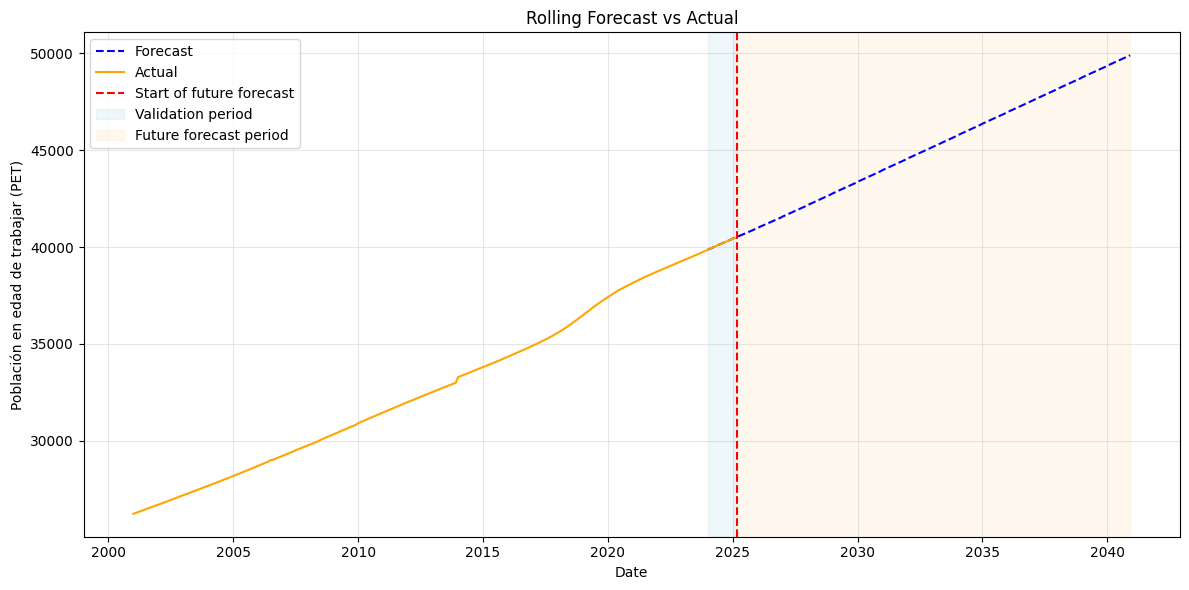

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(12, 6))
plt.plot(rolling_forecast_val['ds'], rolling_forecast_val['forecast'], label='Forecast', color='blue', linestyle='--')
plt.plot(df_labor['ds'], df_labor['Población en edad de trabajar (PET)'], label='Actual', color='orange')
plt.axvline(x=pd.to_datetime("2025-03-01"), color='red', linestyle='--', label='Start of future forecast')
plt.axvspan('2024-01-01', '2025-02-01', color='lightblue', alpha=0.2, label='Validation period')
plt.axvspan('2025-03-01', '2040-12-01', color='navajowhite', alpha=0.2, label='Future forecast period')
plt.title('Rolling Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Población en edad de trabajar (PET)')
plt.legend()
# Grid
plt.grid(alpha=0.3)

# Ajustar márgenes
plt.tight_layout()
plt.show()


# Entrenando Catboost

🔎 Diagnóstico de la serie original:
ADF Statistic: -5.3081
p-value: 0.0000
✅ La serie es estacionaria.


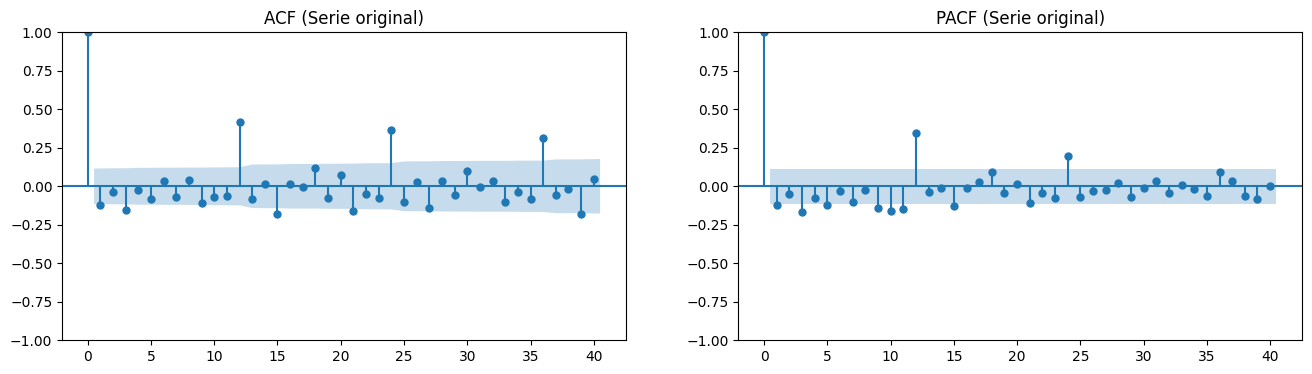

In [5]:
from src.epl_proyection.utils import ts_diagnostics
ts_diagnostics.full_ts_diagnostics(df_labor['logdiff_población ocupada'])

In [7]:
from src.epl_proyection.models.catboost.catboost_feature_engineering import make_features
from src.epl_proyection.models.catboost.catboost_optuna_tuning import catboost_optuna_tuning
from src.epl_proyection.models.catboost.catboost_train_catboost import train_catboost_with_params
import pandas as pd

In [8]:
df = df_labor.copy()
var = 'Población ocupada'
dfsinNa = df.dropna(subset=[var])

if var == 'Población ocupada':
    dfsinNa = make_features(dfsinNa, target_column=var, exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'], lags=[1,2,3], rolling_windows=[1,2,3])
    df =  make_features(df, target_column=var, exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'], lags=[1,2,3], rolling_windows=[1,2,3])
    df_train_a = dfsinNa[(dfsinNa['ds'] >= "2001-01-01") & (dfsinNa['ds'] <= "2014-12-01")]
    df_train_b = dfsinNa[(dfsinNa['ds'] >= "2016-01-01") & (dfsinNa['ds'] <= "2023-12-01")]
    df_train = pd.concat([df_train_a, df_train_b], ignore_index=True)
    df_val = dfsinNa[~dfsinNa['ds'].isin(df_train['ds'])].copy()
    feature_columns = ['workdays', 'weekends', 'holidays','negative_crashes','lag_1','lag_2','lag_3',
                                    'rolling_mean_1','rolling_mean_2','rolling_mean_3','month']

elif var in ['Agricultura, ganadería, caza, silvicultura y pesca', 'Industrias manufactureras']:
    dfsinNa = make_features(dfsinNa, target_column=var, exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'], lags=[1,2,3], rolling_windows=[1,2,3])
    df = make_features(df, target_column=var, exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'], lags=[1,2,3], rolling_windows=[1,2,3])
    min_date = dfsinNa['ds'].min()
    max_date = dfsinNa['ds'].max() - pd.DateOffset(months=12)
    df_train = dfsinNa[(dfsinNa['ds'] >= min_date) & (dfsinNa['ds'] <= max_date)]
    df_val = dfsinNa[~dfsinNa['ds'].isin(df_train['ds'])].copy()
    feature_columns = ['workdays', 'weekends', 'holidays','negative_crashes','lag_1','lag_2','lag_3',
                                    'rolling_mean_1','rolling_mean_2','rolling_mean_3','month']

else:
    dfsinNa = make_features(dfsinNa, target_column=var, exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'], lags=[1], rolling_windows=[1])
    df = make_features(df, target_column=var, exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'], lags=[1], rolling_windows=[1])
    min_date = dfsinNa['ds'].min()
    max_date = dfsinNa['ds'].max() - pd.DateOffset(months=5)
    df_train = dfsinNa[(dfsinNa['ds'] >= min_date) & (dfsinNa['ds'] <= max_date)]
    df_val = dfsinNa[~dfsinNa['ds'].isin(df_train['ds'])].copy()
    feature_columns = ['workdays', 'weekends', 'holidays','negative_crashes','lag_1','rolling_mean_1','month']

study = catboost_optuna_tuning(
    df_train=df_train,
    df_val=df_val,
    target_column=var,
    feature_columns=feature_columns,
    n_trials=4,
    timeout=600
)
best_params = study['best_params']

model_trained = train_catboost_with_params(
    df=df_train,
    target_column=var,
    feature_columns=feature_columns,
    params=best_params
)

df_to_know_data = dfsinNa[dfsinNa['ds'] <= "2025-02-01"].copy()
df_to_know_data[f'pred_{var}'] = model_trained['model'].predict(df_to_know_data[feature_columns])

df_to_future = df.copy()
df_to_future = df_to_future[df_to_future['ds'] >= "2025-03-01"]
df_to_future = pd.concat([df_to_know_data, df_to_future], ignore_index=True)

if var in ['Población ocupada', 'Agricultura, ganadería, caza, silvicultura y pesca', 'Industrias manufactureras']:
    df_to_future = make_features(df_to_future, target_column=var, exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'], lags=[1,2,3], rolling_windows=[1,2,3])
else:
    df_to_future = make_features(df_to_future, target_column=var, exog_columns=['workdays', 'weekends', 'holidays','negative_crashes'], lags=[1], rolling_windows=[1])

future_dates = df_to_future[df_to_future['ds'] >= "2025-03-01"].copy()

for index, row in future_dates.iterrows():
    features = row[feature_columns].values.reshape(1, -1)
    predicted_value = model_trained['model'].predict(features)

    df_to_future.at[index, f'pred_{var}'] = predicted_value

    if var in ['Población ocupada', 'Agricultura, ganadería, caza, silvicultura y pesca', 'Industrias manufactureras']:
        df_to_future.at[index + 1, 'lag_1'] = predicted_value
        if index + 2 in df_to_future.index:
            df_to_future.at[index + 2, 'lag_2'] = predicted_value
        if index + 3 in df_to_future.index:
            df_to_future.at[index + 3, 'lag_3'] = predicted_value

        rolling_vals = df_to_future.loc[max(0, index - 2):index, f'pred_{var}'].dropna().values
        if len(rolling_vals) >= 1:
            df_to_future.at[index + 1, 'rolling_mean_1'] = rolling_vals[-1]
        if len(rolling_vals) >= 2:
            df_to_future.at[index + 1, 'rolling_mean_2'] = rolling_vals[-2:].mean()
        if len(rolling_vals) >= 3:
            df_to_future.at[index + 1, 'rolling_mean_3'] = rolling_vals.mean()
    else:
        df_to_future.at[index + 1, 'lag_1'] = predicted_value
        rolling_vals = df_to_future.loc[max(0, index - 1):index, f'pred_{var}'].dropna().values
        if len(rolling_vals) >= 1:
            df_to_future.at[index + 1, 'rolling_mean_1'] = rolling_vals[-1]
        if len(rolling_vals) >= 2:
            df_to_future.at[index + 1, 'rolling_mean_2'] = rolling_vals.mean()

[I 2025-04-27 13:31:40,129] A new study created in memory with name: no-name-5174bdeb-ce99-410a-a5a1-5cf6dd84c4fa
[I 2025-04-27 13:31:42,719] Trial 0 finished with value: 0.013436289077597943 and parameters: {'iterations': 657, 'learning_rate': 0.0162374902645472, 'depth': 6, 'l2_leaf_reg': 2.6595290957480118, 'bagging_temperature': 0.8804320641090126, 'random_strength': 0.6074979331909854}. Best is trial 0 with value: 0.013436289077597943.
[I 2025-04-27 13:31:46,568] Trial 1 finished with value: 0.014975495571160485 and parameters: {'iterations': 657, 'learning_rate': 0.02470433306610764, 'depth': 8, 'l2_leaf_reg': 0.027731145048708085, 'bagging_temperature': 0.07729249286646456, 'random_strength': 0.5539564380749725}. Best is trial 0 with value: 0.013436289077597943.
[I 2025-04-27 13:31:46,964] Trial 2 finished with value: 0.014869624491059412 and parameters: {'iterations': 349, 'learning_rate': 0.29527777340093847, 'depth': 4, 'l2_leaf_reg': 0.9649978278565475, 'bagging_temperature'

0:	learn: 2327.6624176	total: 3.57ms	remaining: 2.34s
1:	learn: 2298.3083935	total: 5.32ms	remaining: 1.74s
2:	learn: 2268.8276044	total: 6.83ms	remaining: 1.49s
3:	learn: 2239.2722011	total: 8.15ms	remaining: 1.33s
4:	learn: 2208.3747446	total: 11.3ms	remaining: 1.48s
5:	learn: 2179.4106785	total: 13.1ms	remaining: 1.42s
6:	learn: 2151.5790579	total: 13.7ms	remaining: 1.27s
7:	learn: 2124.5775513	total: 14.5ms	remaining: 1.18s
8:	learn: 2094.8358976	total: 15.4ms	remaining: 1.1s
9:	learn: 2070.3182345	total: 16.1ms	remaining: 1.04s
10:	learn: 2044.0428363	total: 16.9ms	remaining: 991ms
11:	learn: 2016.9170679	total: 17.7ms	remaining: 949ms
12:	learn: 1990.9317138	total: 18.9ms	remaining: 935ms
13:	learn: 1966.2774359	total: 21.2ms	remaining: 973ms
14:	learn: 1943.4024448	total: 22.8ms	remaining: 977ms
15:	learn: 1917.4011426	total: 24.2ms	remaining: 968ms
16:	learn: 1892.0542780	total: 25.1ms	remaining: 945ms
17:	learn: 1867.3860008	total: 26.3ms	remaining: 935ms
18:	learn: 1845.46728

In [9]:
df_to_future[df_to_future['ds'] >= "2025-03-01"]

,YearMonth,Year,Month,workdays,weekends,holidays,Población en edad de trabajar (PET),Población ocupada,"Agricultura, ganadería, caza, silvicultura y pesca",Industrias manufactureras,...,ds,lag_1,lag_2,lag_3,rolling_mean_1,rolling_mean_2,rolling_mean_3,year,month,pred_Población ocupada
290,2025-03-01,2025.0,3.0,20.0,10.0,1.0,NaN,NaN,NaN,NaN,...,2025-03-01,23469.477029,22902.834711,23620.681703,23469.477029,23186.155870,23330.997814,2025.0,3.0,22944.654673
291,2025-04-01,2025.0,4.0,20.0,8.0,4.0,NaN,NaN,NaN,NaN,...,2025-04-01,22944.654673,23469.477029,22902.834711,22944.654673,22836.175098,22497.378177,2025.0,4.0,17234.977398
292,2025-05-01,2025.0,5.0,21.0,9.0,1.0,NaN,NaN,NaN,NaN,...,2025-05-01,17234.977398,22944.654673,23469.477029,17234.977398,20089.816036,20969.109198,2025.0,5.0,16497.857653
293,2025-06-01,2025.0,6.0,18.0,9.0,3.0,NaN,NaN,NaN,NaN,...,2025-06-01,16497.857653,17234.977398,22944.654673,16497.857653,16866.417526,18892.496575,2025.0,6.0,14954.872001
294,2025-07-01,2025.0,7.0,23.0,8.0,1.0,NaN,NaN,NaN,NaN,...,2025-07-01,14954.872001,16497.857653,17234.977398,14954.872001,15726.364827,16229.235684,2025.0,7.0,15382.631560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2040-08-01,2040.0,8.0,21.0,8.0,2.0,NaN,NaN,NaN,NaN,...,2040-08-01,14992.688881,14912.169209,14967.469097,14992.688881,14952.429045,14957.442396,2040.0,8.0,15092.110120
476,2040-09-01,2040.0,9.0,20.0,10.0,0.0,NaN,NaN,NaN,NaN,...,2040-09-01,15092.110120,14992.688881,14912.169209,15092.110120,15042.399500,14998.989403,2040.0,9.0,15475.406550
477,2040-10-01,2040.0,10.0,22.0,8.0,1.0,NaN,NaN,NaN,NaN,...,2040-10-01,15475.406550,15092.110120,14992.688881,15475.406550,15283.758335,15186.735184,2040.0,10.0,15518.441826
478,2040-11-01,2040.0,11.0,20.0,8.0,2.0,NaN,NaN,NaN,NaN,...,2040-11-01,15518.441826,15475.406550,15092.110120,15518.441826,15496.924188,15361.986166,2040.0,11.0,15312.980279


In [12]:
var = 'Población ocupada'
df = df_labor.copy()
dfsinNa = df.dropna(subset=['Población ocupada'])
dfsinNa = make_features(dfsinNa, target_column='Población ocupada', lags=[1, 2, 3], 
                        rolling_windows=[1, 2, 3])
df_train_a = dfsinNa[(dfsinNa['ds'] >= "2001-01-01") & (dfsinNa['ds'] <= "2014-12-01")]
df_train_b = dfsinNa[(dfsinNa['ds'] >= "2016-01-01") & (dfsinNa['ds'] <= "2023-12-01")]
df_train = pd.concat([df_train_a, df_train_b], ignore_index=True)
df_val = dfsinNa[~dfsinNa['YearMonth'].isin(df_train['YearMonth'])].copy()
feature_columns = ['workdays', 'weekends', 'holidays','negative_crashes','lag_1','lag_2','lag_3',
                                    'rolling_mean_1','rolling_mean_2','rolling_mean_3','month']
study = catboost_optuna_tuning(
            df_train=df_train,
            df_val=df_val,
            target_column=var,
            feature_columns=feature_columns,
            n_trials=30,
            timeout=600
        )
best_params = study['best_params']

model_trained = train_catboost_with_params(
    df=df_train,
    target_column=var,
    feature_columns=feature_columns,
    params=best_params
)

[I 2025-04-27 13:11:00,959] A new study created in memory with name: no-name-8622daeb-7c5c-4694-b771-ef27182804cf
[I 2025-04-27 13:11:01,708] Trial 0 finished with value: 0.012253565191090256 and parameters: {'iterations': 686, 'learning_rate': 0.028219477123206924, 'depth': 4, 'l2_leaf_reg': 0.6109838485554522, 'bagging_temperature': 0.32297661755141116, 'random_strength': 0.5008338667878235}. Best is trial 0 with value: 0.012253565191090256.
[I 2025-04-27 13:11:15,412] Trial 1 finished with value: 0.018072460018780767 and parameters: {'iterations': 860, 'learning_rate': 0.2521215260940867, 'depth': 10, 'l2_leaf_reg': 0.004885700436345855, 'bagging_temperature': 0.974747744112004, 'random_strength': 0.38741786195355254}. Best is trial 0 with value: 0.012253565191090256.
[I 2025-04-27 13:11:17,274] Trial 2 finished with value: 0.01433444927369165 and parameters: {'iterations': 572, 'learning_rate': 0.022961539901049148, 'depth': 7, 'l2_leaf_reg': 0.056561860285825466, 'bagging_temperat

0:	learn: 2211.0050241	total: 545us	remaining: 375ms
1:	learn: 2076.9472293	total: 993us	remaining: 341ms
2:	learn: 1959.9245349	total: 1.35ms	remaining: 308ms
3:	learn: 1841.7549042	total: 2.93ms	remaining: 500ms
4:	learn: 1732.6737700	total: 3.38ms	remaining: 462ms
5:	learn: 1642.0577133	total: 5.29ms	remaining: 602ms
6:	learn: 1551.8807332	total: 5.73ms	remaining: 557ms
7:	learn: 1465.2043217	total: 6.8ms	remaining: 578ms
8:	learn: 1387.2945372	total: 7.55ms	remaining: 570ms
9:	learn: 1310.9249366	total: 8.01ms	remaining: 543ms
10:	learn: 1253.7016461	total: 8.62ms	remaining: 530ms
11:	learn: 1190.4151785	total: 9.1ms	remaining: 513ms
12:	learn: 1136.6931802	total: 9.53ms	remaining: 495ms
13:	learn: 1078.6726512	total: 9.97ms	remaining: 480ms
14:	learn: 1034.2856748	total: 15.2ms	remaining: 680ms
15:	learn: 986.8020869	total: 15.8ms	remaining: 663ms
16:	learn: 946.5646700	total: 16.4ms	remaining: 648ms
17:	learn: 905.8460836	total: 16.9ms	remaining: 630ms
18:	learn: 868.6260075	tota

In [15]:
df_to_know_data = dfsinNa[dfsinNa['ds'] <= "2025-02-01"].copy()
df_to_know_data[f'pred_{var}'] = model_trained['model'].predict(df_to_know_data[feature_columns])
df_to_future = df.copy()
df_to_future = df_to_future[df_to_future['ds'] >= "2025-03-01"]
df_to_predict = pd.concat([df_to_know_data, df_to_future], ignore_index=True)

In [20]:
df_to_predict['lag_1'] = df_to_predict['Población ocupada'].shift(1)
df_to_predict['lag_2'] = df_to_predict['Población ocupada'].shift(2)
df_to_predict['lag_3'] = df_to_predict['Población ocupada'].shift(3)

In [4]:
from src.epl_proyection.models.catboost.catboost_main_pipeline import run_catboost_pipeline

# Correr todo el pipeline
df_final = run_catboost_pipeline(df_labor, n_trials = 5)

# Ver el resultado
print(df_final.head())


[I 2025-04-27 13:38:56,947] A new study created in memory with name: no-name-16a9d48e-100b-48fc-9d10-e453ee6c4a86
[I 2025-04-27 13:38:59,208] Trial 0 finished with value: 2.780446937672366 and parameters: {'iterations': 773, 'learning_rate': 0.012861117573240703, 'depth': 7, 'l2_leaf_reg': 0.006419148813152884, 'bagging_temperature': 0.5773378961081881, 'random_strength': 0.6247270085820092}. Best is trial 0 with value: 2.780446937672366.
[I 2025-04-27 13:39:01,334] Trial 1 finished with value: 2.30559388466084 and parameters: {'iterations': 941, 'learning_rate': 0.022613809662504532, 'depth': 7, 'l2_leaf_reg': 0.2570131434439665, 'bagging_temperature': 0.8393272901491742, 'random_strength': 0.24220364606264466}. Best is trial 1 with value: 2.30559388466084.
[I 2025-04-27 13:39:01,689] Trial 2 finished with value: 2.368604039178974 and parameters: {'iterations': 337, 'learning_rate': 0.13287415168435812, 'depth': 5, 'l2_leaf_reg': 0.34684309027695376, 'bagging_temperature': 0.420600705

0:	learn: 0.0221509	total: 19.1ms	remaining: 10.3s
1:	learn: 0.0189466	total: 29.9ms	remaining: 8.04s
2:	learn: 0.0164106	total: 48.2ms	remaining: 8.62s
3:	learn: 0.0143318	total: 59.3ms	remaining: 7.94s
4:	learn: 0.0129234	total: 64.8ms	remaining: 6.93s
5:	learn: 0.0116691	total: 74.5ms	remaining: 6.63s
6:	learn: 0.0106157	total: 86.3ms	remaining: 6.57s
7:	learn: 0.0099337	total: 92.8ms	remaining: 6.17s
8:	learn: 0.0090479	total: 106ms	remaining: 6.24s
9:	learn: 0.0084594	total: 112ms	remaining: 5.93s
10:	learn: 0.0080303	total: 120ms	remaining: 5.77s
11:	learn: 0.0076565	total: 126ms	remaining: 5.54s
12:	learn: 0.0072255	total: 133ms	remaining: 5.39s
13:	learn: 0.0069877	total: 141ms	remaining: 5.29s
14:	learn: 0.0065909	total: 148ms	remaining: 5.16s
15:	learn: 0.0063745	total: 154ms	remaining: 5.03s
16:	learn: 0.0060329	total: 161ms	remaining: 4.94s
17:	learn: 0.0057659	total: 169ms	remaining: 4.89s
18:	learn: 0.0054929	total: 174ms	remaining: 4.78s
19:	learn: 0.0051108	total: 182ms

[I 2025-04-27 13:39:14,152] A new study created in memory with name: no-name-f8131afd-92c9-4070-b3ee-5c43978e235e
[I 2025-04-27 13:39:14,580] Trial 0 finished with value: 1.6024774239993453 and parameters: {'iterations': 499, 'learning_rate': 0.15978908303225461, 'depth': 4, 'l2_leaf_reg': 0.08820204159143595, 'bagging_temperature': 0.8395896388619377, 'random_strength': 0.13928743316459657}. Best is trial 0 with value: 1.6024774239993453.
[I 2025-04-27 13:39:15,267] Trial 1 finished with value: 2.0005804972410837 and parameters: {'iterations': 434, 'learning_rate': 0.03540495080796224, 'depth': 6, 'l2_leaf_reg': 0.002222848921666148, 'bagging_temperature': 0.8727182420127654, 'random_strength': 0.8103028709657563}. Best is trial 0 with value: 1.6024774239993453.
[I 2025-04-27 13:39:16,218] Trial 2 finished with value: 1.8613942043914957 and parameters: {'iterations': 602, 'learning_rate': 0.028559840720447635, 'depth': 6, 'l2_leaf_reg': 0.056501417979628106, 'bagging_temperature': 0.0

0:	learn: 0.0779380	total: 1.86ms	remaining: 926ms
1:	learn: 0.0712158	total: 2.92ms	remaining: 724ms
2:	learn: 0.0664544	total: 3.19ms	remaining: 527ms
3:	learn: 0.0621642	total: 3.45ms	remaining: 427ms
4:	learn: 0.0588318	total: 3.7ms	remaining: 366ms
5:	learn: 0.0547241	total: 4.09ms	remaining: 336ms
6:	learn: 0.0516421	total: 4.59ms	remaining: 323ms
7:	learn: 0.0494850	total: 4.91ms	remaining: 302ms
8:	learn: 0.0464042	total: 5.25ms	remaining: 286ms
9:	learn: 0.0440347	total: 5.56ms	remaining: 272ms
10:	learn: 0.0417293	total: 5.95ms	remaining: 264ms
11:	learn: 0.0403049	total: 6.26ms	remaining: 254ms
12:	learn: 0.0384340	total: 6.51ms	remaining: 243ms
13:	learn: 0.0372552	total: 8ms	remaining: 277ms
14:	learn: 0.0355499	total: 8.35ms	remaining: 269ms
15:	learn: 0.0349613	total: 8.6ms	remaining: 260ms
16:	learn: 0.0340239	total: 8.85ms	remaining: 251ms
17:	learn: 0.0329421	total: 9.11ms	remaining: 243ms
18:	learn: 0.0318652	total: 9.59ms	remaining: 242ms
19:	learn: 0.0313502	total:

[I 2025-04-27 13:39:22,740] A new study created in memory with name: no-name-2f8001ea-7964-467c-97a6-cae13805c781
[I 2025-04-27 13:39:27,862] Trial 0 finished with value: 1.175733253742534 and parameters: {'iterations': 921, 'learning_rate': 0.010444535941675371, 'depth': 9, 'l2_leaf_reg': 0.0709489445374296, 'bagging_temperature': 0.9743483661528417, 'random_strength': 0.6729446974211508}. Best is trial 0 with value: 1.175733253742534.
[I 2025-04-27 13:39:34,213] Trial 1 finished with value: 1.3553173485941237 and parameters: {'iterations': 822, 'learning_rate': 0.1830013034156422, 'depth': 10, 'l2_leaf_reg': 0.03515231716170607, 'bagging_temperature': 0.7467261101755625, 'random_strength': 0.36409329710310134}. Best is trial 0 with value: 1.175733253742534.
[I 2025-04-27 13:39:38,082] Trial 2 finished with value: 1.0400526782798825 and parameters: {'iterations': 781, 'learning_rate': 0.018188354735409158, 'depth': 9, 'l2_leaf_reg': 0.005762614416290674, 'bagging_temperature': 0.16597

0:	learn: 0.0929474	total: 9.9ms	remaining: 7.72s
1:	learn: 0.0919217	total: 13ms	remaining: 5.07s
2:	learn: 0.0911661	total: 13.9ms	remaining: 3.6s
3:	learn: 0.0900569	total: 21ms	remaining: 4.08s
4:	learn: 0.0889099	total: 23.4ms	remaining: 3.64s
5:	learn: 0.0876583	total: 26.9ms	remaining: 3.47s
6:	learn: 0.0865626	total: 29ms	remaining: 3.2s
7:	learn: 0.0853828	total: 34.2ms	remaining: 3.31s
8:	learn: 0.0842534	total: 37.6ms	remaining: 3.22s
9:	learn: 0.0834876	total: 38.5ms	remaining: 2.97s
10:	learn: 0.0827135	total: 39.4ms	remaining: 2.76s
11:	learn: 0.0818653	total: 41.3ms	remaining: 2.65s
12:	learn: 0.0808295	total: 43.3ms	remaining: 2.56s
13:	learn: 0.0798230	total: 48.8ms	remaining: 2.67s
14:	learn: 0.0788964	total: 51.8ms	remaining: 2.65s
15:	learn: 0.0780359	total: 54ms	remaining: 2.58s
16:	learn: 0.0768961	total: 58.2ms	remaining: 2.62s
17:	learn: 0.0759003	total: 62.8ms	remaining: 2.66s
18:	learn: 0.0749538	total: 66.9ms	remaining: 2.68s
19:	learn: 0.0741245	total: 70.1m

[I 2025-04-27 13:39:48,366] A new study created in memory with name: no-name-7b9207ae-d56c-4adb-ac6f-30103f6d82d4
[I 2025-04-27 13:39:48,860] Trial 0 finished with value: 2.250172960668213 and parameters: {'iterations': 523, 'learning_rate': 0.03655804345253086, 'depth': 6, 'l2_leaf_reg': 0.07375803754015864, 'bagging_temperature': 0.2456863846959252, 'random_strength': 0.35714026913853636}. Best is trial 0 with value: 2.250172960668213.
[I 2025-04-27 13:39:49,701] Trial 1 finished with value: 2.12487682837118 and parameters: {'iterations': 613, 'learning_rate': 0.01153034316806277, 'depth': 7, 'l2_leaf_reg': 0.0071147560004411565, 'bagging_temperature': 0.40363814168083656, 'random_strength': 0.5310254347231279}. Best is trial 1 with value: 2.12487682837118.
[I 2025-04-27 13:39:50,020] Trial 2 finished with value: 2.158503617613648 and parameters: {'iterations': 539, 'learning_rate': 0.10141773472483982, 'depth': 5, 'l2_leaf_reg': 0.037880873421466656, 'bagging_temperature': 0.9879009

0:	learn: 0.0232087	total: 329us	remaining: 300ms
1:	learn: 0.0229332	total: 1.2ms	remaining: 544ms
2:	learn: 0.0225085	total: 1.53ms	remaining: 465ms
3:	learn: 0.0222775	total: 1.73ms	remaining: 393ms
4:	learn: 0.0219906	total: 2.33ms	remaining: 423ms
5:	learn: 0.0216125	total: 2.84ms	remaining: 429ms
6:	learn: 0.0212485	total: 3.37ms	remaining: 436ms
7:	learn: 0.0207907	total: 3.6ms	remaining: 407ms
8:	learn: 0.0204895	total: 3.96ms	remaining: 398ms
9:	learn: 0.0202115	total: 4.63ms	remaining: 418ms
10:	learn: 0.0199727	total: 4.97ms	remaining: 408ms
11:	learn: 0.0196881	total: 6.64ms	remaining: 499ms
12:	learn: 0.0195257	total: 7.22ms	remaining: 500ms
13:	learn: 0.0192771	total: 7.55ms	remaining: 485ms
14:	learn: 0.0190371	total: 7.75ms	remaining: 464ms
15:	learn: 0.0188066	total: 7.94ms	remaining: 445ms
16:	learn: 0.0186147	total: 8.12ms	remaining: 428ms
17:	learn: 0.0183348	total: 8.3ms	remaining: 413ms
18:	learn: 0.0179920	total: 8.51ms	remaining: 401ms
19:	learn: 0.0177691	total

[I 2025-04-27 13:39:52,086] A new study created in memory with name: no-name-45e42315-d5b9-4146-bb30-1a40d50182b7
[I 2025-04-27 13:39:52,578] Trial 0 finished with value: 1.4993203503604677 and parameters: {'iterations': 577, 'learning_rate': 0.027670673851542232, 'depth': 6, 'l2_leaf_reg': 0.0019209793250261344, 'bagging_temperature': 0.867880667313904, 'random_strength': 0.6431091820165508}. Best is trial 0 with value: 1.4993203503604677.
[I 2025-04-27 13:39:53,797] Trial 1 finished with value: 1.2679673163200538 and parameters: {'iterations': 627, 'learning_rate': 0.057089177478392775, 'depth': 9, 'l2_leaf_reg': 0.02523063805869384, 'bagging_temperature': 0.20429720143587304, 'random_strength': 0.6781983155472104}. Best is trial 1 with value: 1.2679673163200538.
[I 2025-04-27 13:39:55,728] Trial 2 finished with value: 1.404397554141237 and parameters: {'iterations': 674, 'learning_rate': 0.02134633413419372, 'depth': 10, 'l2_leaf_reg': 2.691652267921793, 'bagging_temperature': 0.411

0:	learn: 0.0285775	total: 614us	remaining: 385ms
1:	learn: 0.0273907	total: 959us	remaining: 300ms
2:	learn: 0.0263851	total: 1.25ms	remaining: 260ms
3:	learn: 0.0253308	total: 2.02ms	remaining: 315ms
4:	learn: 0.0242735	total: 2.44ms	remaining: 304ms
5:	learn: 0.0233869	total: 2.66ms	remaining: 275ms
6:	learn: 0.0223190	total: 3.36ms	remaining: 298ms
7:	learn: 0.0216109	total: 3.65ms	remaining: 282ms
8:	learn: 0.0207283	total: 4.38ms	remaining: 301ms
9:	learn: 0.0198894	total: 5.45ms	remaining: 336ms
10:	learn: 0.0190912	total: 6.46ms	remaining: 362ms
11:	learn: 0.0186009	total: 6.99ms	remaining: 358ms
12:	learn: 0.0179199	total: 7.59ms	remaining: 359ms
13:	learn: 0.0174050	total: 7.87ms	remaining: 345ms
14:	learn: 0.0169222	total: 8.09ms	remaining: 330ms
15:	learn: 0.0162855	total: 11.3ms	remaining: 431ms
16:	learn: 0.0155707	total: 12.5ms	remaining: 449ms
17:	learn: 0.0150351	total: 14.1ms	remaining: 476ms
18:	learn: 0.0144644	total: 15ms	remaining: 481ms
19:	learn: 0.0139165	total

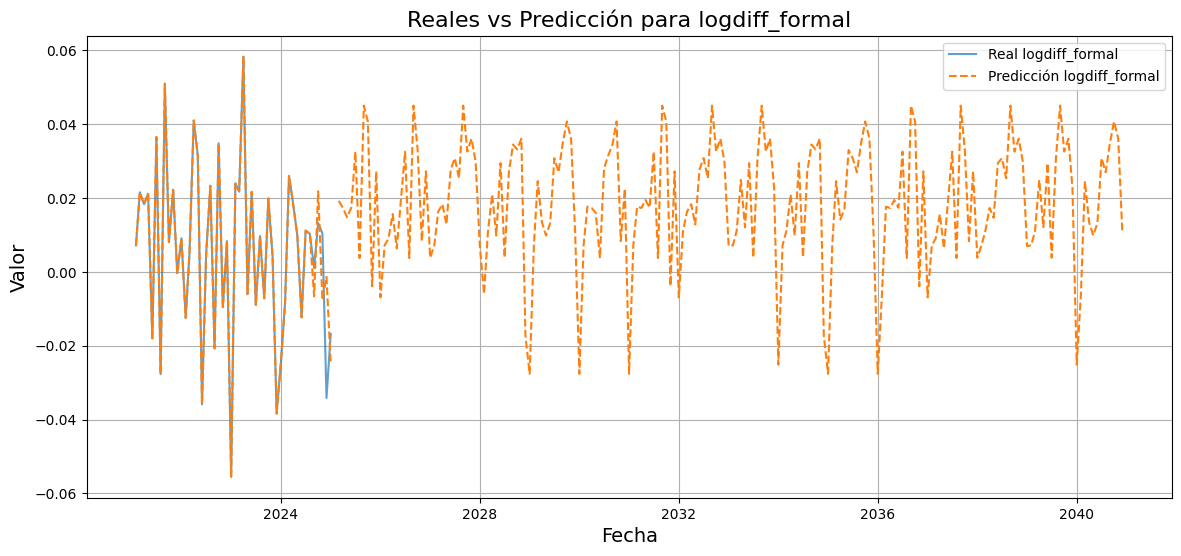

In [10]:
import matplotlib.pyplot as plt

def plot_real_vs_pred(df_final, variable):
    """
    Grafica valores reales vs predichos para una variable específica.

    Args:
        df_final (pd.DataFrame): DataFrame que contiene las columnas de valores reales y predichos.
        variable (str): Nombre de la variable a graficar.
    """

    plt.figure(figsize=(14, 6))
    plt.plot(df_final['ds'], df_final[variable], label=f'Real {variable}', alpha=0.7)
    plt.plot(df_final['ds'], df_final[f'pred_{variable}'], label=f'Predicción {variable}', linestyle='--')
    plt.title(f'Reales vs Predicción para {variable}', fontsize=16)
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Valor', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# --- USO ---
# Solo cambias esta variable y corres todo el chunk de nuevo
variable = 'logdiff_formal'  # Cambia aquí el nombre de la variable que quieres ver
plot_real_vs_pred(df_final, variable)
